In [13]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def generate_dataframe(edit_counts):
    # Convert data to a pandas DataFrame
    df = pd.DataFrame(edit_counts)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [3]:
# Function to identify peaks based on the rolling mean of the past 3 years
def find_peaks_rolling_3_years(df, threshold_percentage=0.30):
    peaks = []
    
    # Iterate over each timestamp
    for i in range(len(df)):  # Start from the first element
        # Get data within the last 3 years
        past_3_years_data = df[df['timestamp'] <= df['timestamp'][i]]
        past_3_years_data = past_3_years_data[past_3_years_data['timestamp'] >= (df['timestamp'][i] - pd.DateOffset(years=3))]

        # Calculate the rolling mean of the last 3 years (average of 'edits' in the past 3 years)
        rolling_mean = past_3_years_data['edits'].mean()

        # Calculate the threshold (mean + 30%)
        threshold = rolling_mean * (1 + threshold_percentage)
        
        # Check if the current value is above the threshold
        if df['edits'][i] >= threshold:
            peaks.append((df['timestamp'][i], df['edits'][i], rolling_mean, threshold))

    return peaks

In [15]:
# Log peaks (timestamp, edits, rolling mean, threshold)
def log_peaks(peaks):
    for peak in peaks:
        print(f"Peak: {peak[0].strftime('%Y-%m-%d')}, Edits: {peak[1]}, Rolling Mean: {peak[2]:.2f}, Threshold: {peak[3]:.2f}, percentage difference : {(peak[1]-peak[2])*100/peak[2]}")


In [16]:
base_url = "https://wikimedia.org/api/rest_v1/metrics/edits/aggregate"

project = "uz.wikipedia.org"      
editor_type = "all-editor-types"  
page_type = "all-page-types"      
granularity = "monthly"           
start = "20140101"                
end = "20240101"  

rolling_window = 3
# Set the threshold percentage (30%)
threshold_percentage = 0.30


url = f"{base_url}/{project}/{editor_type}/{page_type}/{granularity}/{start}/{end}"

response = requests.get(url)


if response.status_code == 200:
    data = response.json()
    #print("Number of edits data:")
    #print(data)
else:
    print(f"Error: {response.status_code} - {response.text}")
    
    
edit_counts=data["items"][0]["results"]

df = generate_dataframe(edit_counts)
peaks = find_peaks_rolling_3_years(df, threshold_percentage)
log_peaks(peaks)

Peak: 2014-04-01, Edits: 6288, Rolling Mean: 3329.25, Threshold: 4328.03, percentage difference : 88.87136742509574
Peak: 2014-05-01, Edits: 5368, Rolling Mean: 3737.00, Threshold: 4858.10, percentage difference : 43.64463473374364
Peak: 2014-12-01, Edits: 8661, Rolling Mean: 3445.00, Threshold: 4478.50, percentage difference : 151.4078374455733
Peak: 2015-01-01, Edits: 13979, Rolling Mean: 4255.31, Threshold: 5531.90, percentage difference : 228.50738444295814
Peak: 2015-02-01, Edits: 6269, Rolling Mean: 4399.14, Threshold: 5718.89, percentage difference : 42.50503344807431
Peak: 2015-03-01, Edits: 9001, Rolling Mean: 4705.93, Threshold: 6117.71, percentage difference : 91.26917791723923
Peak: 2015-08-01, Edits: 39533, Rolling Mean: 6039.20, Threshold: 7850.96, percentage difference : 554.6065704066765
Peak: 2015-09-01, Edits: 70141, Rolling Mean: 9091.67, Threshold: 11819.17, percentage difference : 671.4867094408801
Peak: 2015-11-01, Edits: 28937, Rolling Mean: 9645.26, Threshold: 1

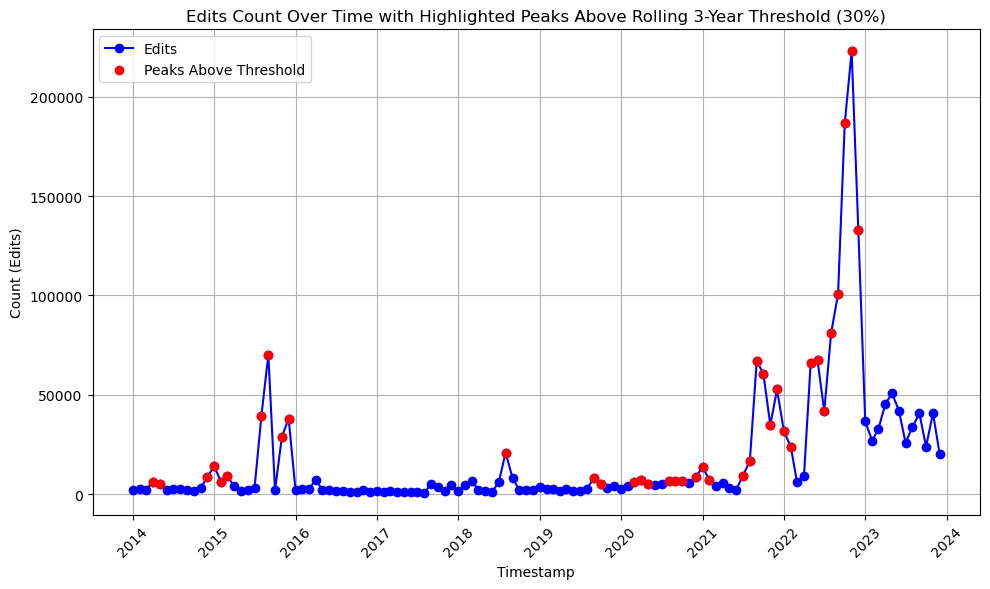

In [14]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['edits'], marker='o', linestyle='-', color='b', label='Edits')

# Highlight the peaks above the rolling threshold
peak_timestamps = [peak[0] for peak in peaks]
peak_values = [peak[1] for peak in peaks]
plt.scatter(peak_timestamps, peak_values, color='red', zorder=5, label='Peaks Above Threshold')

# Add labels and title
plt.title(f"Edits Count Over Time with Highlighted Peaks Above Rolling 3-Year Threshold (30%)")
plt.xlabel("Timestamp")
plt.ylabel("Count (Edits)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.legend()
plt.show()